In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import waterfall_chart

In [2]:
file = pd.read_stata('hctms_data.dta')

## Wybrane zmienne - preprocessing
##### Ilościowe
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q9** - wiek partnera w 2017

##### Jakościowe
- **Q27** - czy ty i twój partner dorastaliście w tym samym mieście?
- **w6_q32**- czy wykorzystałeś internet do poznania partnera?

In [3]:
dt = file[['w6_number_people_met','age_when_met','Q9', 'ppage','w6_q32','S1','Q27','w6_q21b_year','w6_q21c_year','Q21A_Year','w6_q9']].dropna().reset_index(drop = True)

In [4]:
# S1 - Is married?
dt['S1'] = 1 - dt['S1'].cat.codes


# w6_q32 - Did you use internet to meet partner?
dt['w6_q32'] = dt['w6_q32'].str.replace('No.*','0')
dt['w6_q32'] = dt['w6_q32'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['w6_q32'] == 'Refused')]
dt['w6_q32'] = pd.to_numeric(dt['w6_q32'])

# Q27 - The same city with partner?
dt['Q27'] = dt['Q27'].str.replace('No.*','0')
dt['Q27'] = dt['Q27'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['Q27'] == 'Refused')]
dt['Q27'] = pd.to_numeric(dt['Q27'])

# Q21A_Year - In what Year and Month did you first meet 
dt = dt.loc[~(dt['Q21A_Year'] == 'Refused')]
dt['Q21A_Year'] = pd.to_numeric(dt['Q21A_Year'])

# w6_q9 - Partner age in 2017

features = dt[['Q21A_Year','w6_q9','Q27','w6_q32']]
labels = dt[['S1']]

In [5]:
features.head(10)

,Q21A_Year,w6_q9,Q27,w6_q32
0,1983,52.0,0,0
1,2006,45.0,0,1
2,1983,59.0,0,0
3,1981,60.0,0,0
4,1966,67.0,1,0
5,1967,65.0,1,0
6,2008,43.0,0,0
7,2007,35.0,0,0
8,2002,42.0,0,0
9,2007,37.0,0,0


In [6]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.10, random_state = 0)

#XGBoost
from xgboost import XGBClassifier
model_xgb = XGBClassifier(max_depth=3)
model_xgb.fit(train_features,train_labels)
predictions = model_xgb.predict(test_features)
tested_labels = np.array(test_labels)
model_xgb.score(test_features,test_labels)
model_xgb.predict(test_features)
model_xgb.predict_proba(test_features)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_xgb, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 84.65 %


## LIME

In [166]:
from sklearn.preprocessing import normalize    
from sklearn import tree

def perturbate(features, sample_index, cols_to_perturbate, sd_proc, n):
    """
    cols_to_perturbate - list of length 2 with indexes of columns that we want to perturbate
    sd_proc - percent of sd we want new data to be perturbated
    """
    
    # Sd of selected columns
    col_1_sd_proc = float(features.iloc[:,[cols_to_perturbate[0]]].std()) * sd_proc
    col_2_sd_proc = float(features.iloc[:,[cols_to_perturbate[1]]].std()) * sd_proc 
    
    # Create new data frame and fill with perturbated data
    sample_row=features.iloc[[sample_index],:]
    x_prim=sample_row.append([sample_row]*(n-1),ignore_index=True)
    x_prim_default = x_prim.copy()
    x_prim.iloc[:,[cols_to_perturbate[0]]]=np.random.normal(sample_row.iloc[:,cols_to_perturbate[0]].values , col_1_sd_proc, n)
    x_prim.iloc[:,[cols_to_perturbate[1]]]=np.random.normal(sample_row.iloc[:,cols_to_perturbate[1]].values , col_2_sd_proc, n)
    
    # Weights calculation - normalized euclidean distance
    weights=np.sqrt(((x_prim.iloc[:,cols_to_perturbate].values - x_prim_default.iloc[:,cols_to_perturbate].values)**2).sum(axis=1))
    normalized_weights=normalize(weights.reshape(-1,1), axis=0).reshape(n,)
    
    return x_prim, normalized_weights

def plot_lime(model, features, row, cols, sd, n):
    colnames = features.columns
    x_prim, weights = perturbate(features, row, cols, sd, n)
    
    # Predict perturbated data with Black Box
    y_prim = model.predict(x_prim)
    
    # Fit predicted perturbated data by White Box
    clf = tree.DecisionTreeClassifier(max_depth=2)
    clf = clf.fit(x_prim, y_prim, sample_weight = weights)
    
    # Plot
    import matplotlib.pyplot as plt
    plt.scatter(x_prim.iloc[:,cols[0]],x_prim.iloc[:,cols[1]], c=clf.predict(x_prim))
    plt.xlabel(colnames[cols[0]])
    plt.ylabel(colnames[cols[1]])
    plt.show()
    return sum(clf.predict(x_prim))/n

## Breakdown

In [150]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.models.formatters import NumeralTickFormatter
output_notebook()

class Breakdown():
    def __init__(self, model, features, row, order):
        self.model = model
        self.features = features
        self.row = row
        self.colnames = features.columns
        self.order = order
        
        self.reordered = [self.colnames[i] for i in order]
        
    def breakdown_calculate(self):   
        features = self.features.values
        result = [np.mean(self.model.predict_proba(self.features)[:,1])]

        row = self.row.values[0]
        features_tmp = features.copy()
        for i in self.order:
            features_tmp[:,[i]] = row[i]
            result.append(np.mean(self.model.predict_proba(pd.DataFrame(features_tmp, columns = self.colnames))[:,1]))
        result = pd.DataFrame(data={"var":['intercept'] + list(self.reordered), "proba":result})
        result['diff'] = result['proba'].diff().fillna(result['proba'])
        return result
    
    def breakdown_plot(self):
        x = self.breakdown_calculate()
        
        ### Calculate features needed by Bokeh
        x['y_start'] = x['proba'] - x['diff']
        x['label_pos'] = x['proba']
        x['color'] = 'grey'
        x.loc[x['diff'] < 0, 'color'] = 'red'
        x.loc[x['diff'] >= 0, 'color'] = 'green'
        x.loc[x['diff'] < 0, 'label_pos'] = x.label_pos - 0.05
        net = x['diff'].sum()
        df_net = pd.DataFrame.from_records([('net', net, net, 0, net, 'blue')],
                                           columns=['var', 'proba', 'diff', 'y_start', 'label_pos', 'color'],
                                           index=["net"])
        x = x.append(df_net).reset_index()

        x['xrange'] = pd.Series([i +0.5 for i in range(x.shape[0])])
        x["bar_label"] = x["diff"].map('{:,.2f}'.format)
        source = ColumnDataSource(x)

        p = figure(x_range=list(x['var']), y_range=(0, 1.1),
                   plot_width=600, plot_height=300)

        p.segment(x0='xrange', y0='y_start', x1="xrange", y1='proba',
                  source=source, color="color", line_width=90)

        p.grid.grid_line_alpha=0.3

        labels = LabelSet(x='xrange', y='label_pos', text='bar_label',
                          text_font_size="8pt", level='glyph',
                          x_offset=-20, y_offset=0, source=source)
        p.add_layout(labels)
        show(p)

Loading BokehJS ...

## Analiza wyników

Dwie zmienne ciągłe które będziemy perturbować:
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q9** - wiek partnera w 2017

Model lokalny jaki będzie wykorzystywany w rozwiązaniu to **Drzewo klasyfikacyjne o maksymalnej długości 2**

#### Analizowany przypadek:

In [182]:
features.iloc[[12],:]

,Q21A_Year,w6_q9,Q27,w6_q32
12,1973,72.0,0,0


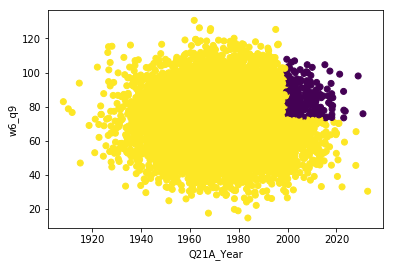

0.9768

In [172]:
plot_lime(model_xgb, features, 12, [0,1], 1, 10000)

Na wykresie Lime widzimy że lokalny model wyznaczył bardzo małą płąszczyznę na której przewiduje niską szansę na związek małżeński dla tego przypadku. Można zauważyć, że jeżeli wybrana osoba poznałaby swojego partnera po roku $2000$ i ten miałby już więcej niż ~60 lat, to szanse na małżeństwo byłyby niskie. Napisałem 60 lat, ponieważ zmienna *w6_q9* opisuje wiek partnera w 2017 roku, więc należy odjąć odpowiednią liczbę lat. Jednak pozostałych przypadkach jest odwrotnie. Wydaje się to naturalne, im partnerzy młodziej się poznali tym większa szansa na małżeństwo.

Poniżej na wykresach breakdown dla wybranej obserwacji, możemy zauważyć, że rok $1973$ w którym poznali się partnerzy pozytywnie wpływa na decyzje modelu w obu kolejnościach. Jednak jeżeli najpierw w breakdownie zmieniamy *wiek partnera w 2017 roku* to można zauważyć że przynosi on negatywny efekt dla modelu. Może to być związane z tym że większość ludzi w badaniu poznała się dosyć późno (widać to po średnim roku poznania partnera wyliczonym poniżej)

In [181]:
# Średni rok w którym partnerzy się poznali
float(features[['Q21A_Year']].mean())

1991.6966966966968

In [176]:
row = features.iloc[[12],:]
brk = Breakdown(model_xgb, features, row, [0,1,2,3])
brk.breakdown_plot()

<img src="bokeh_plot.png">

In [177]:
row = features.iloc[[12],:]
brk = Breakdown(model_xgb, features, row, [3,2,1,0])
brk.breakdown_plot()

<img src="bokeh_plot (1).png">